##Imports

In [ ]:
from google.colab import files
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

##Loading Data

In [ ]:
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samekrangarajan1","key":"df74bf68a743502a9e88df880485221c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d mohitsingh1804/plantvillage
!unzip -q plantvillage.zip -d plantvillage

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0


In [ ]:
root_path = "/content/plantvillage/PlantVillage/train"
print(os.listdir(root_path))

['Tomato___Tomato_mosaic_virus', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Common_rust_', 'Tomato___healthy', 'Corn_(maize)___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Pepper,_bell___healthy', 'Raspberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Soybean___healthy', 'Apple___Black_rot', 'Potato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Peach___healthy', 'Tomato___Target_Spot', 'Apple___healthy', 'Strawberry___Leaf_scorch', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___healthy', 'Blueberry___healthy', 'Tomato___Leaf_Mold', 'Squash___Powdery_mildew', 'Apple___Apple_scab', 'Pepper,_bell___B

In [ ]:
train_dir = "/content/plantvillage/PlantVillage/train"
val_dir = "/content/plantvillage/PlantVillage/val"
filtered_train_dir = "/content/filtered_plantvillage/train"
filtered_val_dir = "/content/filtered_plantvillage/val"

wanted_classes = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
    'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight',
    'Strawberry___healthy', 'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

def copy_filtered_classes(src_dir, dst_dir, class_list):
    os.makedirs(dst_dir, exist_ok=True)
    for class_name in class_list:
        src_path = os.path.join(src_dir, class_name)
        dst_path = os.path.join(dst_dir, class_name)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dst_path)
        else:
            print(f"[Warning] Not found: {src_path}")

copy_filtered_classes(train_dir, filtered_train_dir, wanted_classes)
copy_filtered_classes(val_dir, filtered_val_dir, wanted_classes)

In [ ]:
val_dir = "/content/filtered_plantvillage/val"
test_dir = "/content/filtered_plantvillage/test"

# Create the test set by moving 20% from val to test
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    test_files, keep_val_files = train_test_split(files, test_size=0.8, random_state=42)

    # Make class dirs
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for f in test_files:
        shutil.move(os.path.join(class_path, f), os.path.join(test_dir, class_name))

##Augementation

In [ ]:
img_height, img_width = 224, 224
batch_size = 32

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=25,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation, just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_directory(
    "/content/filtered_plantvillage/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_loader = val_datagen.flow_from_directory(
    "/content/filtered_plantvillage/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 32000 images belonging to 33 classes.
Found 6410 images belonging to 33 classes.


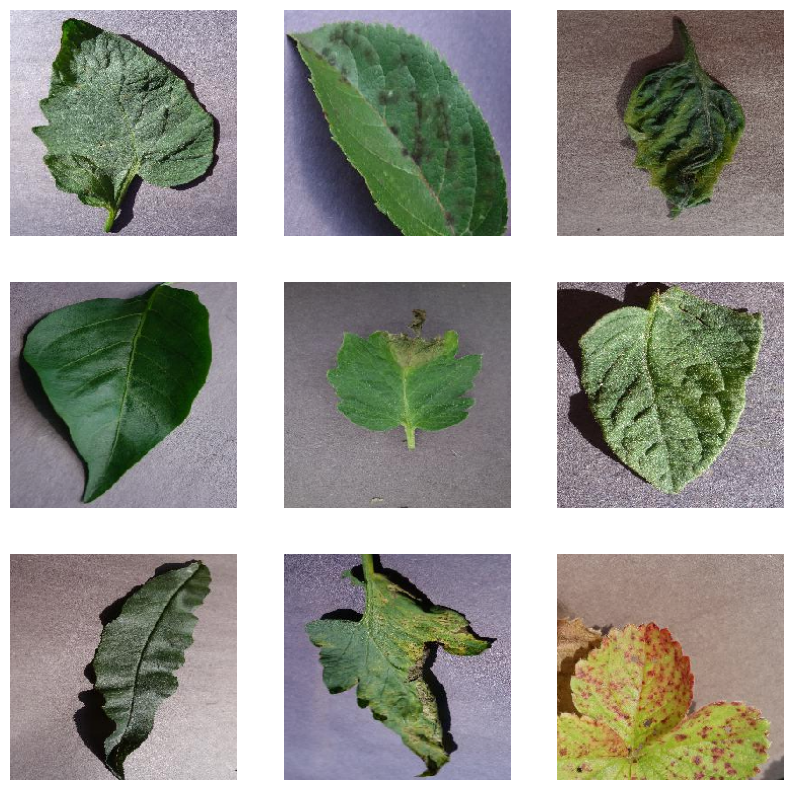

In [ ]:
# Get a batch
images, labels = next(train_loader)

# Show 9 examples
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

##Model training

In [ ]:
# Load base DenseNet121
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base layers (initial training)
base_model.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_loader.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.5563 - loss: 1.6564 - val_accuracy: 0.8903 - val_loss: 0.4121
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 135s 135ms/step - accuracy: 0.8520 - loss: 0.4827 - val_accuracy: 0.9179 - val_loss: 0.2952
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.8788 - loss: 0.3872 - val_accuracy: 0.9112 - val_loss: 0.2860
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.8861 - loss: 0.3481 - val_accuracy: 0.9342 - val_loss: 0.2235
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.8885 - loss: 0.3378 - val_accuracy: 0.9356 - val_loss: 0.2241
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 144s 130ms/step - accuracy: 0.8936 - loss: 0.3241 - val_accuracy: 0.9343 - val_loss: 0.2083
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 130s 129ms/step - accuracy: 0.8978 - loss: 0.3078 - val_accuracy: 0.9410 - val_loss: 0.1939
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - ac

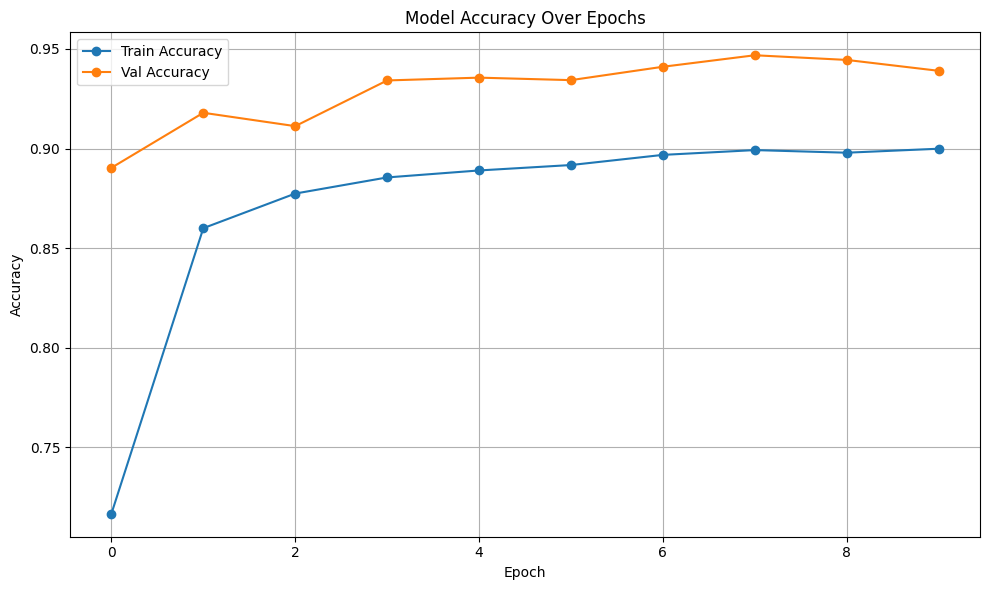

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save to PDF
pdf_path = "accuracy_plot.pdf"
plt.savefig(pdf_path)
plt.show()

In [ ]:
# Save using the new .keras format
model.save("plant_disease_classifier.keras")
print("✅ Model saved as 'plant_disease_classifier.keras'")

✅ Model saved as 'plant_disease_classifier.keras'


##Testing + Evaluation

In [ ]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_loader = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Found 1590 images belonging to 33 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.9475 - loss: 0.1436
Test Accuracy: 0.9352
Test Loss: 0.1928


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step


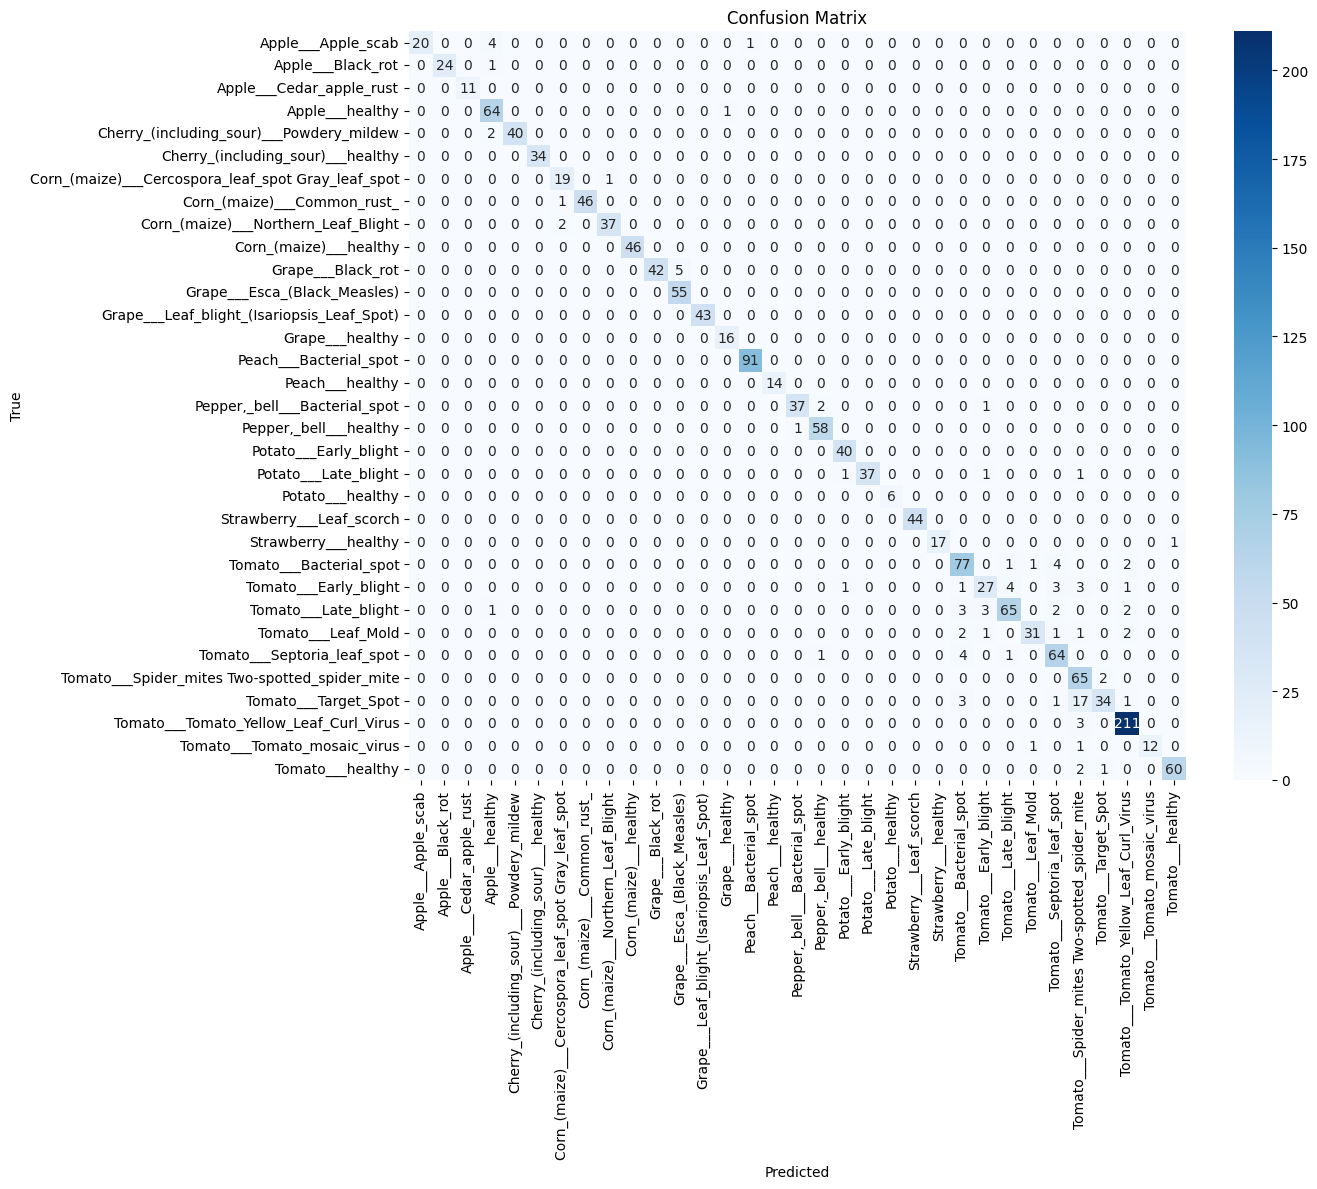

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.80      0.89        25
                                 Apple___Black_rot       1.00      0.96      0.98        25
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        11
                                   Apple___healthy       0.89      0.98      0.93        65
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.98        42
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        34
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.95      0.90        20
                       Corn_(maize)___Common_rust_       1.00      0.98      0.99        47
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.95      0.96        39
                            Corn_(maize)___healthy       1.00      1.00      1.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Get ground truth labels and predicted labels
true_labels = test_loader.classes
class_names = list(test_loader.class_indices.keys())

# Predict on test data
pred_probs = model.predict(test_loader)
pred_labels = np.argmax(pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot it
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# ✅ Save before showing
plt.savefig("confusion_matrix.pdf", format='pdf')

# Then show the plot
plt.show()

# Optional: Classification report (precision, recall, F1)
report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages

# 1. Predict
pred_probs = model.predict(test_loader)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_loader.classes
class_names = list(test_loader.class_indices.keys())

# 2. Find misclassifications
misclassified_indices = np.where(pred_labels != true_labels)[0]
misclass_pairs = [(true_labels[i], pred_labels[i]) for i in misclassified_indices]
# Only keep top N misclassified class pairs
from matplotlib.backends.backend_pdf import PdfPages
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Only keep top N misclassified class pairs
most_common_pairs = pair_counts.most_common(2)  # Top 2 most common mistakes

print("Most common misclassifications:")
for (true_idx, pred_idx), count in most_common_pairs:
    print(f"{class_names[true_idx]} ➜ {class_names[pred_idx]} : {count} times")

# Collect ONE image for each misclassification pair
misclass_examples = {}
file_paths = test_loader.filepaths

for idx in misclassified_indices:
    true_idx = true_labels[idx]
    pred_idx = pred_labels[idx]
    key = (true_idx, pred_idx)

    # Only store image if it's one of the top pairs, and we haven't saved one yet
    if key in dict(most_common_pairs) and key not in misclass_examples:
        misclass_examples[key] = file_paths[idx]

# Save these few examples to PDF
pdf_path = "misclassified_examples.pdf"
with PdfPages(pdf_path) as pdf:
    for (true_idx, pred_idx), img_path in misclass_examples.items():
        fig, ax = plt.subplots(figsize=(6, 6))
        fig.suptitle(f'True: {class_names[true_idx]}\nPredicted: {class_names[pred_idx]}', fontsize=14)

        img = load_img(img_path, target_size=(224, 224))
        ax.imshow(img)
        ax.axis('off')

        # Make room for the suptitle
        plt.tight_layout(rect=[0, 0, 1, 0.88])

        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved selected misclassified examples to: {pdf_path}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step
Most common misclassifications:
Tomato___Target_Spot ➜ Tomato___Spider_mites Two-spotted_spider_mite : 17 times
Grape___Black_rot ➜ Grape___Esca_(Black_Measles) : 5 times
Saved selected misclassified examples to: misclassified_examples.pdf


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Loaded model!
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted: Corn_(maize)___Northern_Leaf_Blight | Confidence: 0.95


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


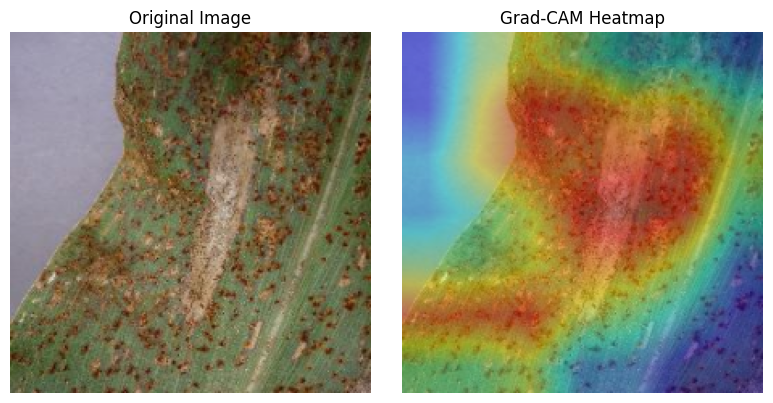

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted: Tomato___Tomato_mosaic_virus | Confidence: 0.84


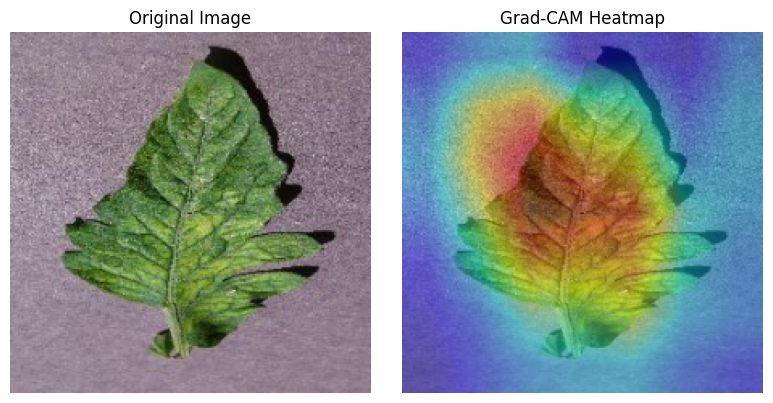

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted: Corn_(maize)___healthy | Confidence: 1.00


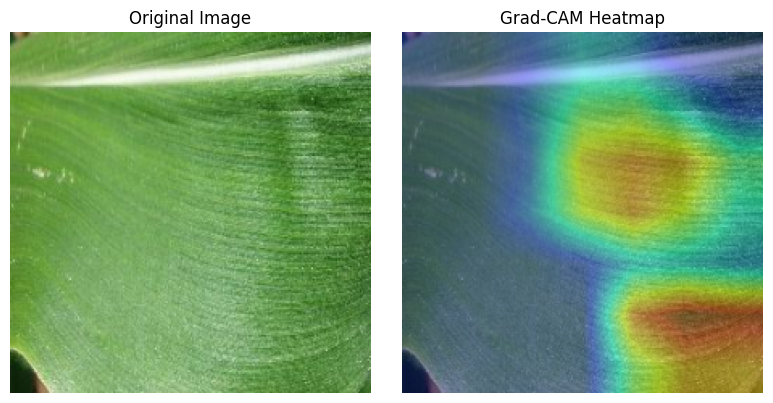

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted: Tomato___Spider_mites Two-spotted_spider_mite | Confidence: 0.82


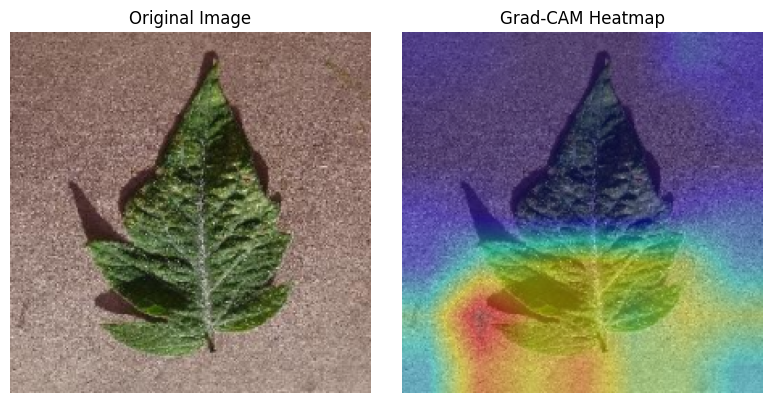

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted: Pepper,_bell___healthy | Confidence: 1.00


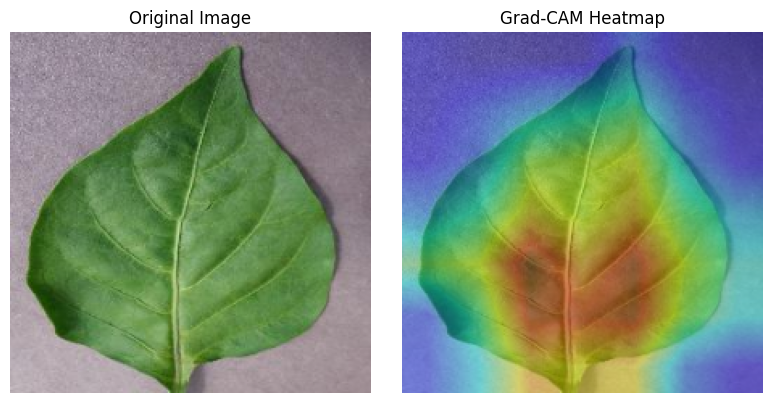

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Load the saved model (.keras recommended) ---
model = load_model("plant_disease_classifier.keras")  # or .h5 if you used that
print("✅ Loaded model!")

# --- Helper functions ---
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize and clean heatmap
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        return np.zeros_like(heatmap)
    heatmap /= np.max(heatmap)
    return heatmap

def display_gradcam_side_by_side(img_path, heatmap, alpha=0.4):
    original = cv2.imread(img_path)
    original = cv2.resize(original, (224, 224))
    img_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original, 1 - alpha, heatmap_colored, alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Show side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_rgb)
    ax[0].set_title("Original Image")
    ax[1].imshow(overlay_rgb)
    ax[1].set_title("Grad-CAM Heatmap")
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

# --- Generate a few Grad-CAMs ---
test_image_paths = []
for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)
    for img_file in os.listdir(class_path)[:1]:  # 1 image per class
        test_image_paths.append(os.path.join(class_path, img_file))

last_conv_layer_name = "conv5_block16_2_conv"

for img_path in test_image_paths[:5]:  # Show 5 results
    img_array = get_img_array(img_path, size=(224, 224))
    preds = model.predict(img_array)
    pred_label = np.argmax(preds[0])
    class_name = list(train_loader.class_indices.keys())[pred_label]

    print(f"Predicted: {class_name} | Confidence: {preds[0][pred_label]:.2f}")

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_label)
    display_gradcam_side_by_side(img_path, heatmap)